In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

**Visualize relationship between probability matrix and ground truth**

In [27]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta, sample_prob=0.1)
    return P, R

beta = np.linspace(0, 2.5, 6)
results = [P_R_train(i) for i in beta]     

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kw

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_31069/3252723565.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


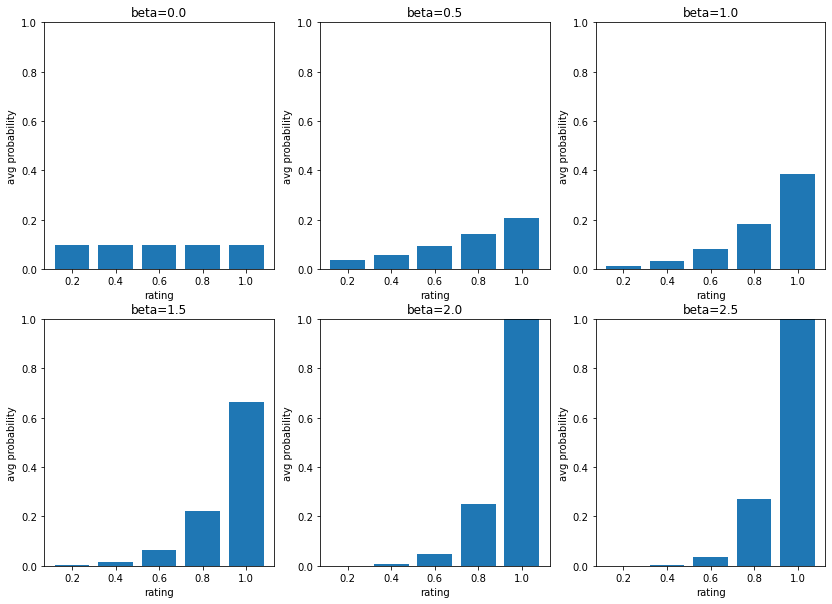

In [36]:
def average_prob(P, R):
    Ps = []
    probs = []
    for i in range(5):
        Ps.append(P.copy())
        probs.append(0)
    for i in range(5):
        Ps[i][R != (0.2 * i + 0.2)] = 0
        probs[i] = Ps[i].sum() / np.count_nonzero(Ps[i])
    return probs

fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    P, R = results[i]
    probs = average_prob(P, R)
    x_axis = ['0.2', '0.4', '0.6', '0.8', '1.0']
    axs[i // 3, i % 3].bar(x_axis, probs)
    axs[i // 3, i % 3].set(title=f'beta={beta[i]}', xlabel='rating', ylabel='avg probability', ylim=(0, 1))
fig.show()

**Experiment**

In [31]:
beta = np.linspace(0.1, 5, 10)
quantization = ['binary', 'onetothree', 'onetofive']
user_knn_result_avg = []
user_knn_result_1q = []
user_knn_result_3q = []
item_knn_result_avg = []
item_knn_result_1q = []
item_knn_result_3q = []
svd_result_avg = []
svd_result_1q = []
svd_result_3q = []

algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

for i in range(len(quantization)):

    for iteration in range(10): 

        temp_results = []
        truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')   

        for j in range(len(beta)):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

    user_knn_result_avg.append(temp_results.mean())
    temp_results.sort()
    user_knn_result_1q.append(temp_results[2])
    user_knn_result_3q.append(temp_results[7])

algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

for i in range(len(quantization)):

    for iteration in range(10):

        temp_results = []
        truth = generate_ground_truth_matrix(
            (1000, 1000), environment='ml-100k-v1')

        for j in range(len(beta)):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

    item_knn_result_avg.append(temp_results.mean())
    temp_results.sort()
    item_knn_result_1q.append(temp_results[2])
    item_knn_result_3q.append(temp_results[7])

algo = SVD(verbose=False)  

for i in range(len(quantization)):

    for iteration in range(10): 

        temp_results = []
        truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')   

        for j in range(len(beta)):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

    svd_result_avg.append(temp_results.mean())
    temp_results.sort()
    svd_result_1q.append(temp_results[2])
    svd_result_3q.append(temp_results[7])
   


Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1585
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1901
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2341
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2923
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3227
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/py

NameError: name 'user_knn_result_avg' is not defined

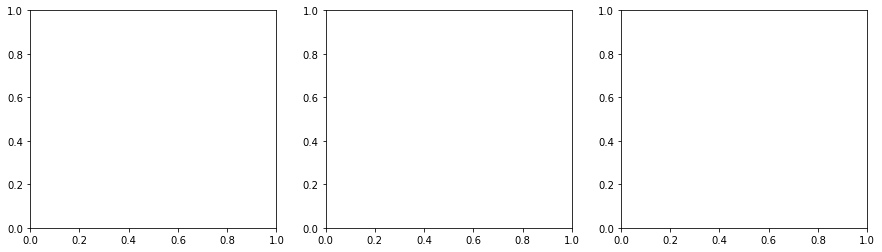

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(beta, user_knn_result_avg[0], label='2-quantization')
axs[0].plot(beta, user_knn_result_avg[1], label='3-quantization')
axs[0].plot(beta, user_knn_result_avg[2], label='5-quantization')
axs[0].fill_between(beta, user_knn_result_1q[0], user_knn_result_3q[0], color='red', alpha=.1)
axs[0].legend()

axs[1].plot(beta, item_knn_result_avg[0], label='2-quantization')
axs[1].plot(beta, item_knn_result_avg[1], label='3-quantization')
axs[1].plot(beta, item_knn_result_avg[2], label='5-quantization')
axs[1].fill_between(beta, item_knn_result_1q[0], item_knn_result_3q[0], color='red', alpha=.1)
axs[1].legend()

axs[2].plot(beta, svd_result_avg[0], label='2-quantization')
axs[2].plot(beta, svd_result_avg[1], label='3-quantization')
axs[2].plot(beta, svd_result_avg[2], label='5-quantization')
axs[2].fill_between(beta, svd_result_1q[0], user_knn_result_3q[0], color='red', alpha=.1)
axs[2].legend()
fig.show()